# # Customer Churn Prediction with Autogluon in Notebook

AutoGluon은 `fit()` 함수 호출만으로 상당히 높은 정확도의 모델을 생성하며, 최신 기능들을 계속 업데이트되고 있습니다. <br>
본 핸즈온에서는 개인 소득이 $50k를 초과하는지 여부를 예측하는 이진 분류 모델을 AutoGluon으로 훈련해 보겠습니다.

In [1]:
install_needed = True  # should only be True once
# install_needed = False

In [2]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
#     !{sys.executable} -m pip install -U split-folders tqdm albumentations crc32c wget
    !{sys.executable} -m pip install 'sagemaker[local]' --upgrade
    !{sys.executable} -m pip install -U smdebug sagemaker-experiments
    !{sys.executable} -m pip install -U sagemaker setuptools wheel numpy scipy 
    !{sys.executable} -m pip install autogluon==0.1.0
    IPython.Application.instance().kernel.do_shutdown(True)

In [3]:
%load_ext autoreload
%autoreload 2
import mxnet
mxnet.__version__

'1.7.0'

## 1. Quick Start

Toy example로 AutoGluon의 저장소에 있는 CSV 데이터셋을 로드하고, 핸즈온을 위해 500건의 데이터만 샘플링합니다.

참고로 TabularDataset은 pandas 데이터프레임과 호환되기 때문에, TabularDataset을 데이터프레임으로 변환하거나 데이터프레임을 TabularDataset로 자유롭게 변환할 수 있습니다.

### Data preparation

In [4]:
%store -r train_data validation_data test_data predictions

In [5]:
from autogluon.tabular import TabularDataset, TabularPredictor

subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)

label = 'Churn?_True.'
print("Summary of |class variable: \n", train_data[label].describe())

y_test = test_data[label]  # values to predict
test_data_nolab = test_data.drop(columns=[label])  # delete label column to prove we're not cheating

Summary of |class variable: 
 count    500.000000
mean       0.510000
std        0.500401
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Churn?_True., dtype: float64


In [6]:
train_data.head(5)

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,...,Area Code_858,Area Code_866,Area Code_868,Area Code_876,Area Code_877,Area Code_878,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
1875,0,156,300,0.615727,4,0.989568,4,3.186399,250,6.299345,...,0,0,0,0,0,0,1,0,0,1
1668,1,175,400,12.875444,3,7.330408,1,6.005570,50,3.356919,...,0,0,0,0,0,0,1,0,0,1
810,0,199,400,7.297431,4,6.188570,2,3.873513,150,5.144417,...,0,0,0,0,0,0,0,1,0,1
4105,0,85,700,0.107730,6,5.816746,2,0.207750,450,4.213836,...,0,0,0,0,0,0,0,1,0,1
3016,0,88,600,3.336338,3,4.169252,3,5.070318,250,4.703822,...,0,0,0,0,0,0,1,0,0,1


### Training

여러분은 단 한 줄의 코드로 쉽게 AutoML을 수행할 수 있습니다.
문제 유형을 지정하지 않아도 자동으로 문제 유형을 파악하며, 별도의 피쳐 인코딩/변환을 수행하지 않아도 되며 결측치 또한 자동으로 처리할 수 있습니다.
이 때, 별도의 검증 데이터셋을 지정하지 않으면, AutoGluon은 데이터의 자동으로 훈련 데이터/검증 데이터를 분리합니다.

AutoGluon은 검증 데이터에서 최고의 성능을 내기 위한 다양한 조합을 반복적으로 수행하며, `fit()`에서 다양한 인수를 지정하여 자유롭게 AutoML을 수행할 수 있습니다.

참고로, Titanic 데이터셋에 아래 설정으로 훈련 수행 시 Kaggle Private LB 기준으로 Top 3%의 accuracy를 보입니다.
(https://www.kaggle.com/innixma/top-3-in-1-line-of-code-w-autogluon)
```python
# Titanic Top 3% accuracy
predictor = TabularPredictor(label=label).fit(train_data, time_limit=3600, num_bag_folds=8)
```

#### Tip 
GPU가 있다면, AutoGluon 0.1부터 LightGBM, CatBoost, XGBoost, NN, FastAI NN 모델 훈련 시 GPU로 훈련이 가능합니다.
```python
predictor = TabularPredictor(..).fit(..., ag_args_fit={'num_gpus': 1})
```

In [7]:
!rm -rf ag-01-binary ag-01-binary-hpo

In [8]:
# time_limit=60 -> 60sec = 1min
save_path = 'ag-01-binary'
predictor = TabularPredictor(label=label, path=save_path).fit(train_data, time_limit=60)

Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "ag-01-binary/"
AutoGluon Version:  0.1.0
Train Data Rows:    500
Train Data Columns: 99
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    26896.09 MB
	Train Data (Original)  Memory Usage: 0.09 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special

[2021-12-05 13:56:35.155 ip-172-16-85-239.us-west-2.compute.internal:4086 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-05 13:56:35.203 ip-172-16-85-239.us-west-2.compute.internal:4086 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


	0.84	 = Validation accuracy score
	2.0s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 54.26s of the 54.25s of remaining time.


	0.79	 = Validation accuracy score
	10.34s	 = Training runtime
	0.23s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 43.68s of the 43.68s of remaining time.
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	0.89	 = Validation accuracy score
	0.43s	 = Training runtime
	0.0s	 = Validation runtime


Fitting model: WeightedEnsemble_L2 ... Training model for up to 59.91s of the 42.14s of remaining time.
	0.89	 = Validation accuracy score
	0.31s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 18.19s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("ag-01-binary/")


### Evaluation

In [9]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:
('float', []) :  4 | ['Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins']
('int', [])   : 95 | ['Account Length', 'VMail Message', 'Day Calls', 'Eve Calls', 'Night Calls', ...]


In [10]:
y_pred = predictor.predict(test_data_nolab)
y_pred.head()

203     0
3567    1
3199    0
4996    0
1024    0
Name: Churn?_True., dtype: int64

In [11]:
y_prob = predictor.predict_proba(test_data_nolab)
y_prob.head()

,0,1
203,0.921164,0.078836
3567,0.017862,0.982138
3199,0.965835,0.034165
4996,0.979514,0.020486
1024,0.608510,0.391490


In [12]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.898
Evaluations on test data:
{
    "accuracy": 0.898,
    "accuracy_score": 0.898,
    "balanced_accuracy_score": 0.8981533340801076,
    "matthews_corrcoef": 0.7963512715032293,
    "f1_score": 0.898
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.9105691056910569,
        "recall": 0.8853754940711462,
        "f1-score": 0.8977955911823648,
        "support": 253
    },
    "1": {
        "precision": 0.8858267716535433,
        "recall": 0.9109311740890689,
        "f1-score": 0.8982035928143713,
        "support": 247
    },
    "accuracy": 0.898,
    "macro avg": {
        "precision": 0.8981979386723,
        "recall": 0.8981533340801076,
        "f1-score": 0.8979995919983681,
        "support": 500
    },
    "weighted avg": {
        "precision": 0.8983463926765252,
        "recall": 0.898,
        "f1-score": 0.897997143988576,
        "support": 500
    }
}


ROC 커브, Precision-Recall 커브, Confusion matrix를 확인합니다. 

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       253
           1       0.89      0.91      0.90       247

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



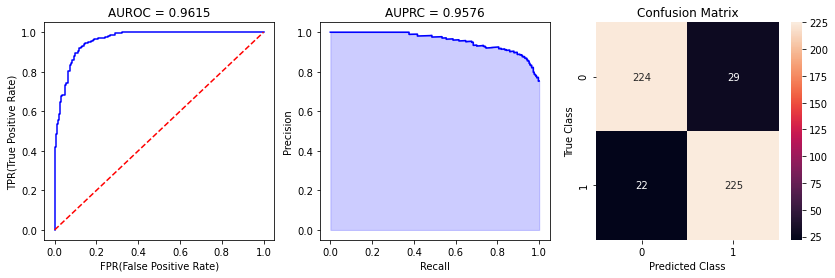

In [13]:
from utils.utils import plot_all
y_prob = predictor.predict_proba(test_data_nolab)
y_prob_ = y_prob.iloc[:,-1]
plot_all(y_test, y_prob_)

In [14]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge       0.89       0.002730   0.428442                0.002730           0.428442            1       True         13
1   WeightedEnsemble_L2       0.89       0.003284   0.740391                0.000554           0.311948            2       True         14
2              LightGBM       0.87       0.003056   0.389704                0.003056           0.389704            1       True          7
3              CatBoost       0.87       0.003955   0.315181                0.003955           0.315181            1       True          9
4               XGBoost       0.87       0.004640   0.239433                0.004640           0.239433            1       True         10
5      RandomForestGini       0.85       0.103842   0.513449                0.103842           0.513449 

In [15]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.89,0.002730,0.428442,0.002730,0.428442,1,True,13
1,WeightedEnsemble_L2,0.89,0.003284,0.740391,0.000554,0.311948,2,True,14
2,LightGBM,0.87,0.003056,0.389704,0.003056,0.389704,1,True,7
3,CatBoost,0.87,0.003955,0.315181,0.003955,0.315181,1,True,9
4,XGBoost,0.87,0.004640,0.239433,0.004640,0.239433,1,True,10
5,RandomForestGini,0.85,0.103842,0.513449,0.103842,0.513449,1,True,1
6,NeuralNetMXNet,0.84,0.018001,1.999744,0.018001,1.999744,1,True,11
7,LightGBMXT,0.83,0.002103,0.112776,0.002103,0.112776,1,True,8
8,RandomForestEntr,0.82,0.103419,0.509830,0.103419,0.509830,1,True,2
9,ExtraTreesEntr,0.80,0.103318,0.407150,0.103318,0.407150,1,True,4


<br>

## 2. Hyperparameter Tuning

`fit()`은 기본적으로 신경망과 다양한 유형의 트리 앙상블 모델을 훈련합니다. 각 모델 유형에 대해 다양한 하이퍼파라메터를 지정할 수 있으며, 각 하이퍼 파라미터에 대해 단일 고정 값을 지정하거나 고려할 하이퍼파라메터의 검색 공간(search space)을 지정할 수 있습니다. 지정하지 않은 하이퍼 파라미터는 AutoGluon에서 자동으로 선택한 기본 설정으로 유지됩니다. 또한, 특정 모델을 훈련 시 제외할 수 있습니다.

아래 코드 셀에서는 NN(Neural Network), GBM(Gradient Boosted Tree), XGB(XGBooost)에 아래의 하이퍼파라메터 조합으로 훈련을 수행하면서
KNN(K-nearest Neighbor), RF(Random Forest)를 제외하는 예시를 보여주고 있습니다.


### Pre-defined presets

AutoGluon은 사전 정의된 6종류의 프리셋을 지원하고 있으며, 각 프리셋 설정에 적합한 하이퍼파라메터 튜닝이 자동으로 수행됩니다.
- best_quality
- best_quality_with_high_quality_refit
- high_quality_fast_inference_only_refit
- good_quality_faster_inference_only_refit
- medium_quality_faster_train
- optimize_for_deployment

best_quality의 성능이 가장 높지만, 훈련 시간이 오래 걸리고 stacking을 위한 디스크 공간을 많이 차지하므로 상황에 따라 적절한 프리셋을 선택해야 합니다. 

In [16]:
import autogluon.core as ag
save_path = 'ag-01-binary-hpo' 

hparams = {
    'NN': {'num_epochs': 5, 'activation': 'relu', 'dropout_prob': ag.Real(0.0, 0.5)},
    'GBM': {'num_boost_round': 100, 'learning_rate': ag.Real(0.01, 0.1, log=True)},
    'XGB': {'n_estimators': 100, 'learning_rate': ag.Real(0.01, 0.1, log=True)}
}

predictor = TabularPredictor(label=label, path=save_path).fit(
    train_data, hyperparameters=hparams, hyperparameter_tune_kwargs='auto', 
    excluded_model_types=['KNN','RF'],
    time_limit=120
)

Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "ag-01-binary-hpo/"
AutoGluon Version:  0.1.0
Train Data Rows:    500
Train Data Columns: 99
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    26683.64 MB
	Train Data (Original)  Memory Usage: 0.09 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 G

In [17]:
y_pred = predictor.predict(test_data_nolab)
y_pred.head()

203     0
3567    1
3199    0
4996    0
1024    0
Name: Churn?_True., dtype: int64

In [18]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM/T22,0.90,0.002201,0.922443,0.002201,0.922443,1,True,23
1,LightGBM/T12,0.90,0.002212,1.408376,0.002212,1.408376,1,True,13
2,WeightedEnsemble_L2,0.90,0.002742,1.769192,0.000530,0.360815,2,True,162
3,LightGBM/T5,0.89,0.002217,1.419714,0.002217,1.419714,1,True,6
4,LightGBM/T3,0.89,0.002231,0.421711,0.002231,0.421711,1,True,4
...,...,...,...,...,...,...,...,...,...
157,NeuralNetMXNet/T25,0.51,0.008067,0.278118,0.008067,0.278118,1,True,142
158,NeuralNetMXNet/T3,0.51,0.008277,0.284442,0.008277,0.284442,1,True,120
159,NeuralNetMXNet/T9,0.51,0.008411,0.286481,0.008411,0.286481,1,True,126
160,NeuralNetMXNet/T44,0.51,0.008523,0.090723,0.008523,0.090723,1,True,161


In [19]:
#predictor.delete_models(models_to_keep=[], dry_run=False)

<br>

## 3. Model Distillation

단일 모델은 일반적으로 weighted/stacked/bagged 앙상블 모델보다 정확도가 낮습니다. 이 때, distillation(증류) 기법을 사용해서 단일 모델의 계산 이점을 유지하면서 앙상블의 성능을 유지할 수 있습니다. 아이디어는 매우 간단하며, 앙상블 모델을 teacher 모델로 하여 teacher 모델의 logit 예측값을 단일 student 모델의 예측값 분포와 유사하게 훈련합니다.

In [20]:
student_models = predictor.distill(time_limit=30)  # specify much longer time limit in real applications
print(student_models)

Distilling with teacher='WeightedEnsemble_L2', teacher_preds=soft, augment_method=spunge ...
SPUNGE: Augmenting training data with 2000 synthetic samples for distillation...
Distilling with each of these student models: ['LightGBM_DSTL', 'NeuralNetMXNet_DSTL', 'CatBoost_DSTL', 'RandomForestMSE_DSTL']
Fitting model: LightGBM_DSTL ... Training model for up to 30.0s of the 30.0s of remaining time.
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's l2: 0.00265153	valid_set's l2: 0.10869


	Note: model has different eval_metric than default.
	-0.1085	 = Validation mean_squared_error score
	11.61s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetMXNet_DSTL ... Training model for up to 18.36s of the 18.36s of remaining time.
	Note: model has different eval_metric than default.
	-0.1	 = Validation mean_squared_error score
	17.97s	 = Training runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_DSTL ... Training model for up to 0.33s of the 0.33s of remaining time.
	Note: model has different eval_metric than default.
	-0.1387	 = Validation mean_squared_error score
	0.32s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE_DSTL ... Training model for up to 0.0s of the -0.0s of remaining time.
	Note: model has different eval_metric than default.
	-0.1201	 = Validation mean_squared_error score
	1.21s	 = Training runtime
	0.1s	 = Validation runtime
Distilling with each of these student models: ['WeightedEnsemble_L2_DSTL']

['LightGBM_DSTL', 'NeuralNetMXNet_DSTL', 'CatBoost_DSTL', 'RandomForestMSE_DSTL', 'WeightedEnsemble_L2_DSTL']


In [21]:
y_pred_student = predictor.predict(test_data_nolab, model=student_models[0])